# CIVE70011 Operational Research and Systems Analysis
### Majd Yousof
### CID: 02061161

To start running this file, it would be recommended to do so in a python `venv` environment, or any other environment management package of your choice. A `requirements.txt` file has been provided that contains the necessary dependencies, that can be installed into the activated environment using the following shell script:

```bash
pip install -r requirements.txt
```
When running this code, please run it all collectively,
Thank you!

In [78]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import zscore
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Part 1: Exploratory Data analysis
In this section, the data and possible insights are extracted.

In [79]:
# loading the dataset
data = pd.read_csv('cw_dataset.csv')
data.head()

,id,house_type,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent
0,1,"2 BHK Flat for Rent in Oberoi Woods, Goregaon ...",Goregaon East,Mumbai,897,2,2,0,Semi-Furnished,134.0,120000.0
1,2,"1 BHK Flat for Rent in Sapphire Lakeside, Powa...",Powai,Mumbai,490,1,1,0,Semi-Furnished,82.0,40000.0
2,3,1 BHK House for Rent in Mundhwa Pune,Mundhwa,Pune,550,1,1,0,Unfurnished,22.0,12000.0
3,4,"2 BHK Flat for Rent in Hingna, Nagpur",Hingna,Nagpur,1000,2,2,0,Unfurnished,8.0,8000.0
4,5,1 BHK Flat for Rent in Unique Star Harsh Vihar...,Mira Road,Mumbai,595,1,1,0,Unfurnished,25.0,15000.0


## Question 1: 
Calculate the mean, standard deviation, and percentiles for each of the numerical features in the dataset, then Calculate the number of apartments at each city and plot the average rent price in each city.

In [80]:
# calculating the means, standard deviations, and percentiles of the area, beds, bathrooms, balconies, area_rate, and rent columns
descriptions = data[['area', 'beds', 'bathrooms', 'balconies', 'area_rate', 'rent']].describe()
descriptions

,area,beds,bathrooms,balconies,area_rate,rent
count,7691.000000,7691.000000,7691.000000,7691.000000,7691.000000,7.691000e+03
mean,1106.354180,2.208685,2.137043,0.817319,47.619989,5.479508e+04
std,1197.426843,0.993481,1.027677,1.243361,68.989657,9.742006e+04
min,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000e+03
25%,600.000000,1.000000,1.000000,0.000000,21.000000,1.500000e+04
50%,900.000000,2.000000,2.000000,0.000000,31.000000,2.800000e+04
75%,1300.000000,3.000000,3.000000,2.000000,54.000000,5.700000e+04
max,70000.000000,10.000000,10.000000,10.000000,2586.000000,2.700000e+06


### A few things that can be noticed from the `descriptions` dataframe:
The maximum values of the features are significantly higher than the 75th percentiles, which indicate that the data contains some outliers, that may skew the results.

In [81]:
# calculating the number of apartments in each city
cityApartmentCount = data['city'].value_counts()

# calculating the mean rent for each city
cityMeanRent = data.groupby('city')['rent'].mean()

citystats = pd.DataFrame({'count': cityApartmentCount, 'meanRent': cityMeanRent})
citystats

,count,meanRent
city,,
Bangalore,1790,56709.260894
Mumbai,1719,103226.538104
Nagpur,595,18015.784874
New Delhi,1808,41309.158739
Pune,1779,32077.928612


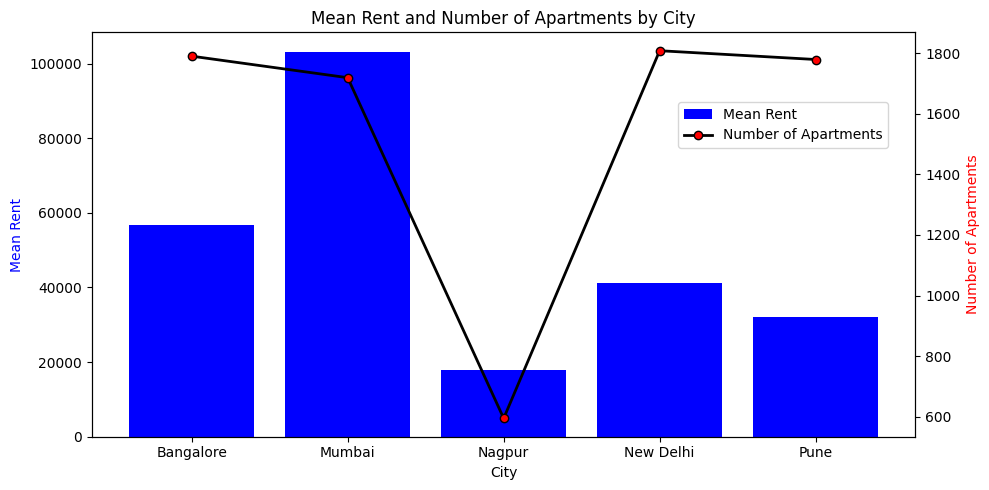

In [82]:
## plotting the mean rent by city, with the number of apartments in each city as a secondary y-axis
fig, ax = plt.subplots(figsize=(10, 5))

# Mean rent by city
ax.bar(citystats.index, citystats['meanRent'], color='blue', label='Mean Rent')
ax.set_ylabel('Mean Rent', color='blue')
ax.set_xlabel('City')
ax.set_title('Mean Rent and Number of Apartments by City')

# Number of apartments by city
ax2 = ax.twinx()
ax2.plot(citystats.index, citystats['count'], color='black', marker='o', mec='black', mfc='red', linewidth=2, label='Number of Apartments')
ax2.set_ylabel('Number of Apartments', color='red')

# Adding the legend
fig.legend(['Mean Rent','Number of Apartments'], loc='upper right', bbox_to_anchor=(0.9, 0.8))

# plotting
plt.tight_layout()
plt.savefig('plots/rawMeanRent.svg')
plt.show()


## Question 2:
Removal of outliers and analysing data again.

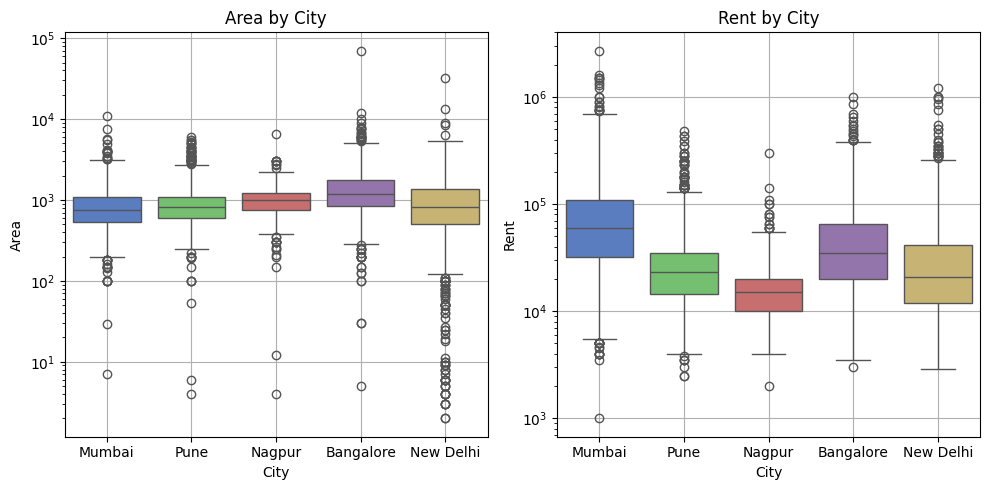

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plotting the boxplot of the area by city
sns.boxplot(data=data, x= 'city', y= 'area', ax=axs[0],log_scale=True, palette='muted6', hue='city')
axs[0].set_title('Area by City')
axs[0].set_ylabel('Area')
axs[0].set_xlabel('City')
axs[0].grid(True)

# plotting the boxplot of the rent by city
sns.boxplot(data=data, x= 'city', y= 'rent', ax=axs[1],log_scale=True, palette='muted6', hue='city')
axs[1].set_title('Rent by City')
axs[1].set_ylabel('Rent')
axs[1].set_xlabel('City')
axs[1].grid(True)

plt.tight_layout()
plt.savefig('plots/compBoxPlot.svg')
plt.show()

These boxplots indicate that there are indeed many outliers within the dataset, however, removing all the outliers that lie beyond the quantiles of the dataset may not be the best option, as there is a significant amount which may affect the representative accuracy of the dataset. this can either be done:
- numerically
- manually through deduction

It would be wise to compare area and rent prices per city (as done below), to capture more information about the outliers. so for manual removal of outliers, this has been done:

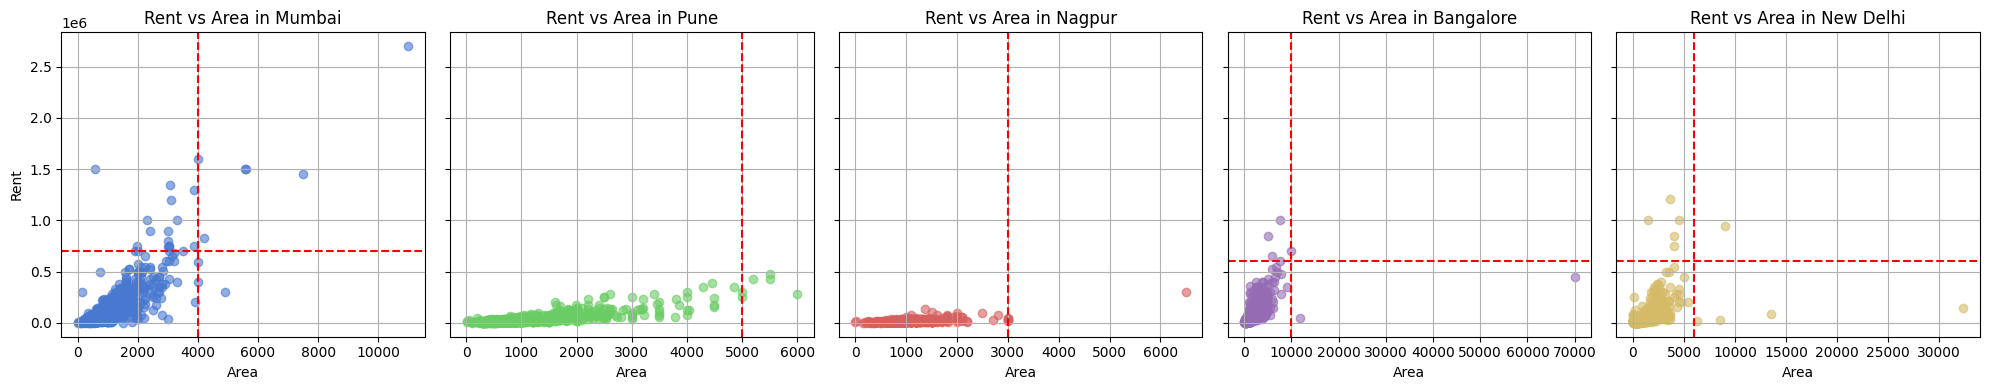

In [84]:
# Get unique cities
cities = data['city'].unique()

# initialising the thresholds for rent and area (explanation in the next cell)
rentthresholds = {'Mumbai': 700000, 'Bangalore': 600000, 'New Delhi': 600000, 'Pune': 1e30, 'Nagpur': 1e30} # 1e30 is a very large number
areathresholds = {'Mumbai': 4000, 'Bangalore': 10000, 'New Delhi': 6000, 'Pune': 5000, 'Nagpur': 3000}

# Create a figure and subplots with a grid of 1 row and len(cities) columns
fig, axs = plt.subplots(1, len(cities), figsize=(20, 4), sharey=True)

# Loop through each city and create a scatter plot for each
for i, city in enumerate(cities):
    city_data = data[data['city'] == city]  # Filter data by city
    axs[i].scatter(city_data['area'], city_data['rent'], color= sns.color_palette('muted6')[i], alpha=0.6, marker='o')

    if city_data.max()['rent'] > rentthresholds[city]:
        axs[i].axhline(rentthresholds[city], color='red', linestyle='--', label='Rent Threshold')
    if city_data.max()['area'] > areathresholds[city]:
        axs[i].axvline(areathresholds[city], color='red', linestyle='--', label='Area Threshold')

    axs[i].set_title(f'Rent vs Area in {city}')
    axs[i].grid(True)
    axs[i].set_xlabel('Area')
    if i == 0:
        axs[i].set_ylabel('Rent')
    
# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('plots/compRentVsArea.svg')
plt.show()

For the Rent vs Area, it is clear that there are a few trends that are visible. It is also true that the visual outliers appear to be far fewer than before, so this plot will be mainly used to determine outliers. For this dataset, the outliers for each city lie **beyond**:

- ***Mumbai:*** Area = 4,000 or Rent = 700,000
- ***Pune:*** Area = 5,000
- ***Nagpur:*** Area = 3,000
- ***Bangalore:*** Area = 10,000 or Rent = 600,000
- ***New Delhi:*** Area = 6000 or Rent = 600,000

It is important to note that these values were ***not numerically calculated.*** To achieve good seperation of outliers numerically, it would be recommended to use `scipy.stats.zscore` to obtain datapoints that lie outside of a specific confidence interval assuming the data is normally distributed. So using the numerical method. for this, the dataframes will be filtered for **apartment type per city**:

In [85]:
# calculating the z-scores for the rent and area columns and creating a dictionary of rent and area thresholds for each city
rentthresholds_auto = {}
areathresholds_auto = {}

# threshold is 3 standard deviations from the mean
for city in cities:
    city_data = data[data['city'] == city]
    city_data['zscore_rent'] = zscore(city_data['rent'])
    city_data['zscore_area'] = zscore(city_data['area'])
    rentthresholds_auto[city] = city_data[city_data['zscore_rent'] < 3]['rent'].max()
    areathresholds_auto[city] = city_data[city_data['zscore_area'] < 3]['area'].max()

C:\Users\majdy\AppData\Local\Temp\ipykernel_31788\3951013239.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['zscore_rent'] = zscore(city_data['rent'])
C:\Users\majdy\AppData\Local\Temp\ipykernel_31788\3951013239.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['zscore_area'] = zscore(city_data['area'])
C:\Users\majdy\AppData\Local\Temp\ipykernel_31788\3951013239.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [86]:
# filtering the data based on the thresholds
data_manual = data.copy()
data_manual = data_manual[data_manual.apply(lambda x: x['rent'] <= rentthresholds[x['city']] and x['area'] <= areathresholds[x['city']], axis=1)].reset_index(drop=True)

data_auto = data.copy()
data_auto = data_auto[data_auto.apply(lambda x: x['rent'] <= rentthresholds_auto[x['city']] and x['area'] <= areathresholds_auto[x['city']], axis=1)].reset_index(drop=True)

Finally, the equivalent barchart can be plotted:

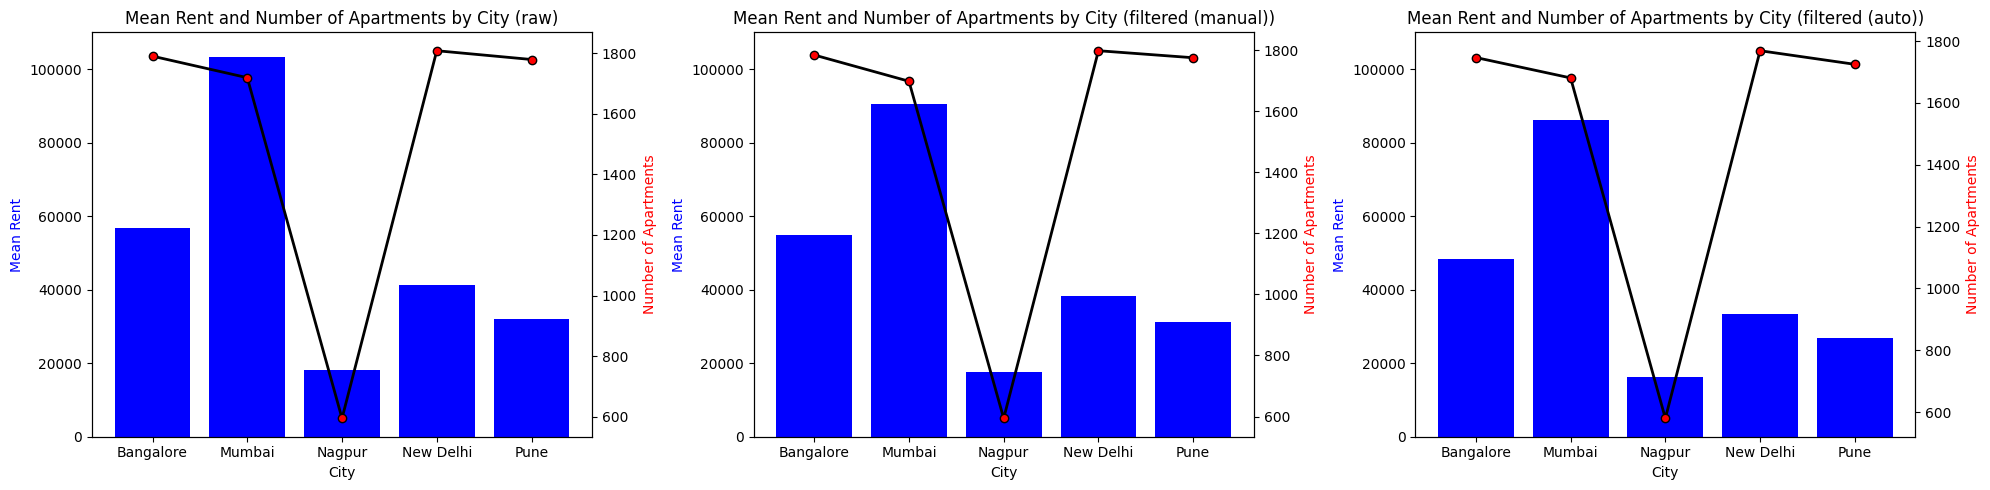

In [87]:
# calculating the number of apartments in each city
cityApartmentCount_manual = data_manual['city'].value_counts()
cityApartmentCount_auto = data_auto['city'].value_counts()

# calculating the mean rent for each city
cityMeanRent_manual = data_manual.groupby('city')['rent'].mean()
cityMeanRent_auto = data_auto.groupby('city')['rent'].mean()

# creating a dataframe with the number of apartments and mean rent for each city
citystats_manual = pd.DataFrame({'count': cityApartmentCount_manual, 'meanRent': cityMeanRent_manual})
citystats_auto = pd.DataFrame({'count': cityApartmentCount_auto, 'meanRent': cityMeanRent_auto})

dflist = [citystats, citystats_manual, citystats_auto]
stringlist = ['raw', 'filtered (manual)', 'filtered (auto)']

## plotting the mean rent by city, with the number of apartments in each city as a secondary y-axis
fig, ax = plt.subplots(1,3, figsize=(20, 5))

for i,df in enumerate(dflist):
    # Mean rent by city
    ax[i].bar(df.index, df['meanRent'], color='blue', label='Mean Rent')
    ax[i].set_ylabel('Mean Rent', color='blue')
    ax[i].set_xlabel('City')
    ax[i].set_title(f'Mean Rent and Number of Apartments by City ({stringlist[i]})')
    ax[i].set_ylim((0, 110000))
    # Number of apartments by city
    ax2 = ax[i].twinx()
    ax2.plot(df.index, df['count'], color='black', marker='o', mec='black', mfc='red', linewidth=2, label='Number of Apartments')
    ax2.set_ylabel('Number of Apartments', color='red')
    

    # Adding the legend
    #fig.legend(['Mean Rent','Number of Apartments'], loc='upper right', bbox_to_anchor=(0.9, 0.8))

# plotting
plt.tight_layout()
plt.savefig('plots/compMeanRent.svg')
plt.show()

Both the manual and the automatic filtration give very similar results, so from now on the **manually filtered dataset** is taken.

# Part 2: Regression

In this section, the focus now lies with the apartment size as the feature, where regressive models are established.

## Question 3:
Apply the least-square method to calculate the intercept and slope for the linear regression
equation that estimates apartment rent.

In [88]:
# function to apply the least squares method
def least_squares(X, y):
    # Calculate the means of X and y
    x_mean = np.mean(X)
    y_mean = np.mean(y)

    # Calculate the numerator and denominator of beta
    numerator = np.sum((X - x_mean) * (y - y_mean))
    denominator = np.sum((X - x_mean) ** 2)

    # Calculate beta
    beta = numerator / denominator

    # Calculate alpha
    alpha = y_mean - beta * x_mean

    return alpha, beta

# Preparing Data for Simple Linear Regression
X = data_manual['area']  # Using only 'area'
y = data_manual['rent']

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Model
alpha_least_squares, beta_least_squares = least_squares(X_train, y_train)

# Making Predictions
predictions_least_squares = alpha_least_squares + beta_least_squares * X_test

# Evaluating the Model
mse_least_squares = mean_squared_error(y_test, predictions_least_squares)
r2_least_squares = r2_score(y_test, predictions_least_squares)
print(f'Simple Linear Regression MSE: {mse_least_squares}')
print(f'Simple Linear Regression R-squared: {r2_least_squares}')

Simple Linear Regression MSE: 3109814682.261755
Simple Linear Regression R-squared: 0.3696825029429981


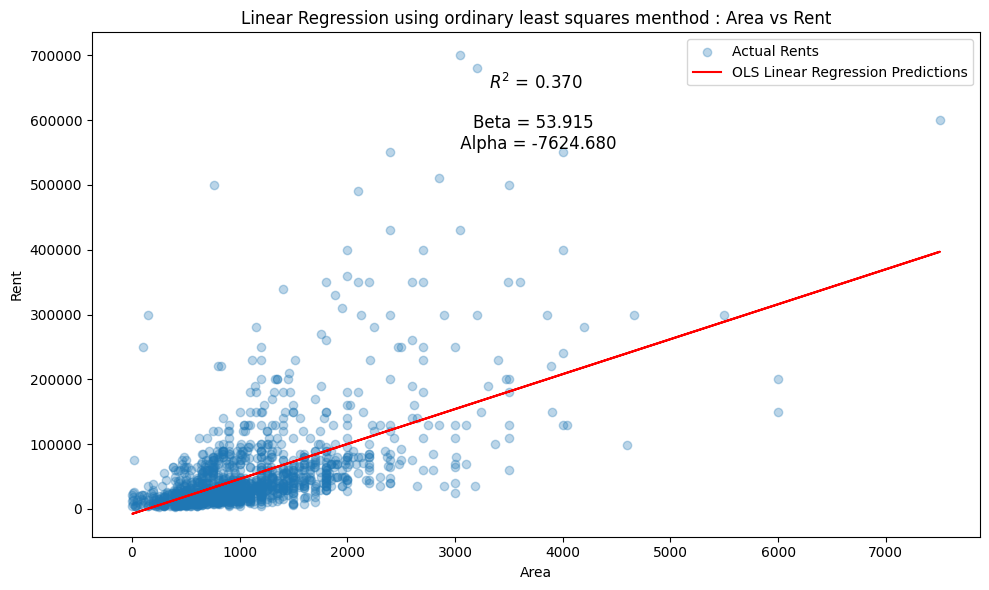

In [89]:
# Plotting least squares Linear Regression Predictions
fig, ax = plt.subplots(1, 1, figsize=(10,6)) 

# Plotting the OLS linear regression predictions
ax.scatter(X_test, y_test, alpha=0.3, label='Actual Rents')
ax.plot(X_test, predictions_least_squares, color='red', label='OLS Linear Regression Predictions')
ax.text(0.5, 0.9, f'$R^2$ = {r2_least_squares:.3f}', ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax.text(0.5, 0.80, f'Beta = {beta_least_squares:.3f} \n Alpha = {alpha_least_squares:.3f}', ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax.set_title('Linear Regression using ordinary least squares menthod : Area vs Rent')
ax.set_xlabel('Area')
ax.set_ylabel('Rent')
ax.legend()

plt.tight_layout()
plt.savefig('plots/OLSLinearRegression.svg')
plt.show()


It is apparent that there is an upward trend within the data, however this model may not be the best in calculating predictions, this can also be taken as a sign that the model is not overfitted; this is due to the fact that $r^2$ (coefficient of determination) is of a relatively low value of 0.370 to 3 dp. From an inferential perspective, its important to know that correlation does not imply causation, and in this case, it is clear that many confounding features are missing from the model which are captured in the noise of the dataset, which is a combination of reducible and irreducible error. There is only so much reducible error that can be mitigated within the a single feature linear regression, and to further increase the accuracy of the model beyond that, it might be worth adding other features such as the number of bedrooms into the model, where their effects have been captured in the irreducible error of the rent predictor. Additionally, there may be a chance that the linear model adopted for the features may not be the best one, (although it seems suitable for this case) and that higher order models are more suitable.

## Question 4
Derive the gradient descent update rule and perform the first 2 iterations.

In [90]:
## Functions to calculate the cost and perform gradient descent taken from the gradient descent notebook

# Function for computing cost (mean squared error)
def compute_cost(alpha, beta, X, y):
    m = len(y)
    predictions = alpha + beta * X
    return (1 / (2 * m)) * np.sum((predictions - y) ** 2)

# Perform gradient descent
def gradient_descent(X, y, alpha, beta, learning_rate, iterations):
    m = len(y)
    cost_history = []
    alpha_history = []
    beta_history = []
    
    for i in range(iterations):
        predictions = alpha + beta * X
        alpha_gradient = (1/m) * np.sum(predictions - y)
        beta_gradient = (1/m) * np.sum((predictions - y) * X)
        
        alpha -= learning_rate * alpha_gradient
        beta -= learning_rate * beta_gradient
        
        cost_history.append(compute_cost(alpha, beta, X, y))
        alpha_history.append(alpha)
        beta_history.append(beta)
        
    return alpha_history, beta_history, cost_history

In [91]:
alpha_initial = -10000 # Initial alpha value
beta_initial = 20 # Initial beta value
learning_rate = 10e-9 # Learning rate
iterations = 2 # Number of iterations

X = X_train
y = y_train

# Running gradient descent
alpha_history, beta_history, cost_history = gradient_descent(X, y, alpha_initial, beta_initial, learning_rate, iterations)

# printing the history of alpha, beta, and cost
print(f'Alpha history: {alpha_history[0]:.3f}, {alpha_history[-1]:.3f}')
print(f'Beta history: {beta_history[0]:.3f}, {beta_history[-1]:.3f}')
print(f'Cost history: {cost_history[0]:.3f}, {cost_history[-1]:.3f}')

Alpha history: -10000.000, -9999.999
Beta history: 20.612, 21.214
Cost history: 2516765526.402, 2480883910.671


## Question 5
Compare the Gradient Descent Linear Regression with the regression calculated in **Question 3**.

In [92]:
# gradient descent implementation with more iterations
new_iterations = 30
alpha_history_comp, beta_history_comp, cost_history_comp = gradient_descent(X, y, alpha_initial, beta_initial, learning_rate, new_iterations)

# evaluating regression the final alpha, beta, and cost
gradient_descent_predictions = alpha_history_comp[-1] + beta_history_comp[-1] * X_test
mse_gradient_descent = mean_squared_error(y_test, gradient_descent_predictions)
r2_gradient_descent = r2_score(y_test, gradient_descent_predictions)
print(f'Gradient Descent MSE: {mse_gradient_descent}')
print(f'Gradient Descent R-squared: {r2_gradient_descent}')

Gradient Descent MSE: 4031894361.1830134
Gradient Descent R-squared: 0.18278938721493643


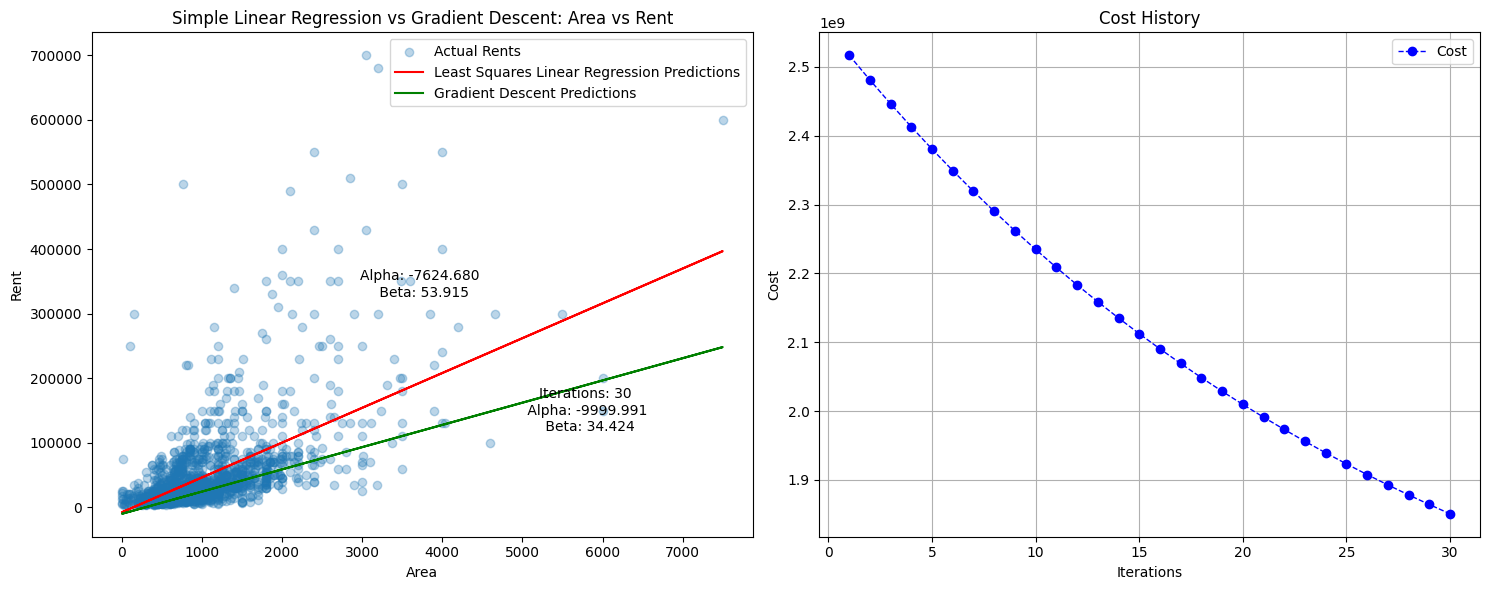

In [93]:
# plotting the comparison of the gradient descent predictions with the simple linear regression predictions

fig, ax = plt.subplots(1, 2, figsize=(15,6)) 

# Plotting the simple linear regression predictions
ax[0].scatter(X_test, y_test, alpha=0.3, label='Actual Rents')
ax[0].plot(X_test, predictions_least_squares, color='red', label='Least Squares Linear Regression Predictions')
ax[0].text(0.5, 0.5, f'Alpha: {alpha_least_squares:.3f} \n Beta: {beta_least_squares:.3f}', ha='center', va='center', transform=ax[0].transAxes)
ax[0].plot(X_test, gradient_descent_predictions, color='green', label='Gradient Descent Predictions')
ax[0].text(0.75, 0.25, f'Iterations: {new_iterations} \n Alpha: {alpha_history_comp[-1]:.3f} \n Beta: {beta_history_comp[-1]:.3f}', 
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[0].set_title('Simple Linear Regression vs Gradient Descent: Area vs Rent')
ax[0].set_xlabel('Area')
ax[0].set_ylabel('Rent')
ax[0].legend()

# Plotting the cost history
ax[1].plot(range(1,new_iterations+1), cost_history_comp, color='blue', label='Cost', marker='o', linestyle='--', linewidth=1)
ax[1].set_title('Cost History')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Cost')
ax[1].legend()
ax[1].grid(True)


# Show the figure
plt.tight_layout()
plt.savefig('plots/gradientDescent.svg')
plt.show()


The following plot visualises this process in 3D, but with a learning rate of $10^{-7}$:

In [94]:
learning = 10e-7 # Learning rate for the plot 30 iterations

# calculating the gradient descent predictions for the grid
alpha_history_plot, beta_history_plot, cost_history_plot = gradient_descent(X, y, alpha_initial, beta_initial, learning, new_iterations)

# Create grid for cost function surface
grid = 150
alpha_plot = np.linspace(np.min(alpha_history_plot)-10, np.max(alpha_history_plot)+10, grid)
beta_plot= np.linspace(np.min(beta_history_plot)-10, np.max(beta_history_plot)+10, grid)
alpha_plot, beta_plot = np.meshgrid(alpha_plot, beta_plot)
cost_plot = np.array([compute_cost(a, b, X, y) for a, b in zip(np.ravel(alpha_plot), np.ravel(beta_plot))])
cost_plot = cost_plot.reshape(alpha_plot.shape)

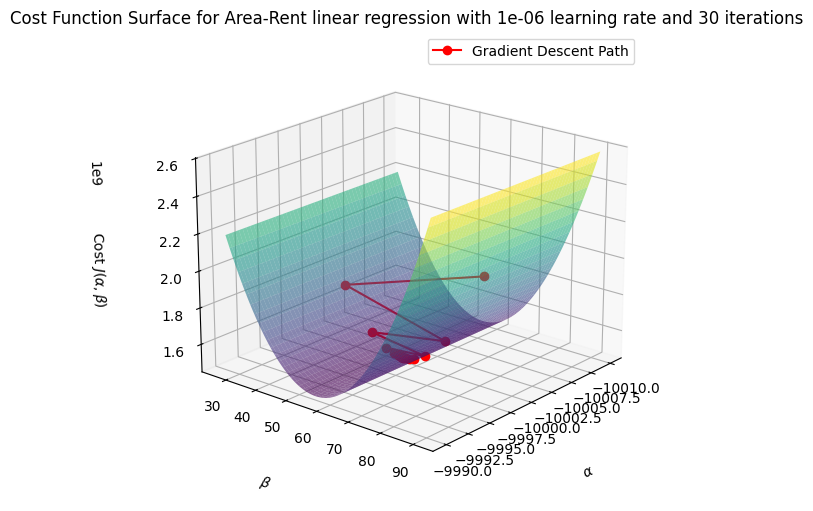

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': '3d'})
a = np.ones(len(alpha_plot))*(alpha_plot.min())
# Plotting the cost function surface
ax.plot_surface(alpha_plot, beta_plot, cost_plot, cmap='viridis', alpha=0.6)


ax.plot3D(alpha_history_plot, beta_history_plot, cost_history_plot, color='red', marker='o', label='Gradient Descent Path')

ax.set_xlabel(r'$\alpha$', labelpad=20)
ax.set_ylabel(r'$\beta$', labelpad=20)
ax.set_zlabel(r'Cost $J(\alpha, \beta)$', labelpad=20)
ax.set_title('Cost Function Surface for Area-Rent linear regression with '+str(learning)+' learning rate and 30 iterations')
ax.legend()

# Adjust view angle
#view = (20, 40)
ax.view_init(*view)

# Ensure layout fits well
fig.set_constrained_layout(True)
# Save with padding
plt.savefig('plots/costFunctionSurfacenew.svg', bbox_inches='tight', pad_inches=1)

plt.show()


The plot indicates that the lack of iterations has provided that the gradient descent model is yet to reach a local or global minima, so it either requires an increase in learning rate or it requires more iterations.

## Question 6
Analyse the effects of learning rate on the gradient descent.

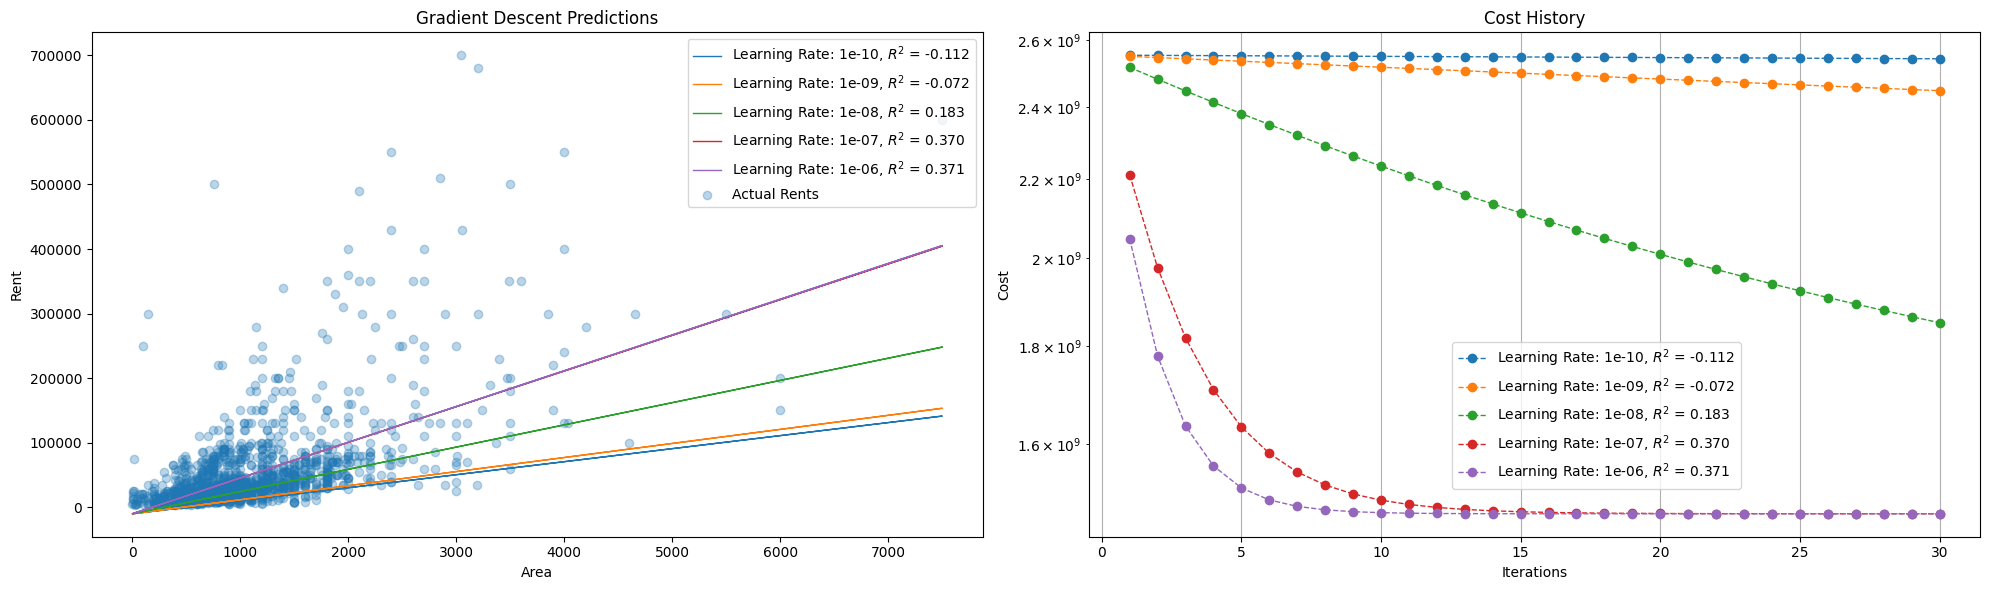

In [96]:
learning_rate_array = [10e-11, 10e-10, 10e-9, 10e-8, 10e-7]

# Running gradient descent for different learning rates
alpha_history_array = []
beta_history_array = []
cost_history_array = []

X = X_train
y = y_train

for learning_rate in learning_rate_array:
    a, b, c = gradient_descent(X, y, alpha_initial, beta_initial, learning_rate, new_iterations)
    alpha_history_array.append(a)
    beta_history_array.append(b)
    cost_history_array.append(c)

# Plotting the cost history for different learning rates
fig, ax = plt.subplots(1, 2, figsize=(20,6))
for i, learning_rate in enumerate(learning_rate_array):

    # Plotting the gradient descent predictions
    gradient_descent_predictions = alpha_history_array[i][-1] + beta_history_array[i][-1] * X_test
    r2 = r2_score(y_test, gradient_descent_predictions)
    ax[0].plot(X_test, gradient_descent_predictions, label=f'Learning Rate: {learning_rate}, $R^2$ = {r2:.3f}', linewidth=1)

    # Plotting the cost history
    ax[1].plot(range(1,new_iterations+1), cost_history_array[i], label=f'Learning Rate: {learning_rate}, $R^2$ = {r2:.3f}', marker='o', linestyle='--', linewidth=1)

# Plotting the actual rents
ax[0].scatter(X_test, y_test, alpha=0.3, label='Actual Rents')
ax[0].set_title('Gradient Descent Predictions')
ax[0].set_xlabel('Area')
ax[0].set_ylabel('Rent')
ax[0].legend()

ax[1].set_title('Cost History')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Cost')
ax[1].legend(bbox_to_anchor=(0.4, 0.4))
ax[1].grid(True)
ax[1].set_yscale('log')

# Show the figure
plt.tight_layout()
plt.savefig('plots/learningRateSlider.svg')
plt.show()


Increase in learning rate 

## Question 7
Discuss the application of gradient descent and suggest alternative termination conditions, instead of number of iterations. Modify the Gradient Descent code to apply an alternative termination condition.

Currently, the termination condition of the gradient descent algorithm is determined by the number of iterations. There are several different other conditions, such as:
- Cost function convergence (||$J_t(\alpha,\beta) - J_{t-1}(\alpha,\beta)$|| < error tolerance)
- Cost function gradient convergence (||$\nabla J_t(\alpha,\beta)$|| < error tolerance)

for this task, the cost function convergence will be used.

In [97]:
# Perform gradient descent using the relative error as the termination condition
def gradient_descent_convergence(X, y, alpha, beta, learning_rate, tolerance, norm_tolerance):
    m = len(y)
    cost_history = []
    alpha_history = []
    beta_history = []
    norm_history = []
    iteration = 0
    error = float('inf')
    norm_error = float('inf')
    
    while True:
        predictions = alpha + beta * X
        alpha_gradient = (1/m) * np.sum(predictions - y)
        beta_gradient = (1/m) * np.sum((predictions - y) * X)
        
        # Update parameters
        alpha -= learning_rate * alpha_gradient
        beta -= learning_rate * beta_gradient

        gradient_norm = np.sqrt(alpha_gradient**2 + beta_gradient**2)
        norm_history.append(gradient_norm)
        
        # Compute cost and track history
        cost_history.append(compute_cost(alpha, beta, X, y))
        alpha_history.append(alpha)
        beta_history.append(beta)

        if iteration > 0:
            error = np.abs((cost_history[-1] - cost_history[-2])/cost_history[-2])
            norm_error = np.abs((norm_history[-1] - norm_history[-2])/norm_history[-2])
        
        # Termination condition: gradient norm below tolerance
        if error < tolerance and norm_error < norm_tolerance:
            print(f"Converged after {iteration+1} iterations")
            break
        
        iteration += 1

    return alpha_history, beta_history, cost_history

In [98]:
tol = 10e-9 # Tolerance change as you see fit
normtol = 0.01 # Tolerance change as you see fit
alpha_new, beta_new, cost_new = gradient_descent_convergence(X, y, alpha_initial, beta_initial, 1e-7, tol,normtol) 
print(f'Alpha: {alpha_new[-1]:.3f}, Beta: {beta_new[-1]:.3f}, Cost: {cost_new[-1]:.3f}')
print(f'Final error: {np.abs((cost_new[-1] - cost_new[-2])/cost_new[-2]):.3f}')

Converged after 69 iterations
Alpha: -9999.973, Beta: 55.390, Cost: 1470624697.188
Final error: 0.000


As can be seen above, the number of iterations is variable as to the error tolerance that is chosen. This method would be more efficient as the condition isn't a certain amount of iterations, it is a condition that directly relates to the accuracy of the model.

## Question 8

Use sk-learn to train a linear regression model and test its accuracy. Determine the accuracy of your model in predicting the rent costs by city

In [99]:
# Training the Model
model_simple = LinearRegression()
model_simple.fit(pd.DataFrame(X_train), y_train)

# Making Predictions
predictions_simple = model_simple.predict(pd.DataFrame(X_test))

# extracting the coefficients and intercept
beta_simple = model_simple.coef_[0]
alpha_simple = model_simple.intercept_

# Evaluating the Model
mse_simple = mean_squared_error(y_test, predictions_simple)
r2_simple = r2_score(y_test, predictions_simple)
print(f'Simple Linear Regression MSE: {mse_simple}')
print(f'Simple Linear Regression R-squared: {r2_simple}')

Simple Linear Regression MSE: 3109814682.2617545
Simple Linear Regression R-squared: 0.3696825029429982


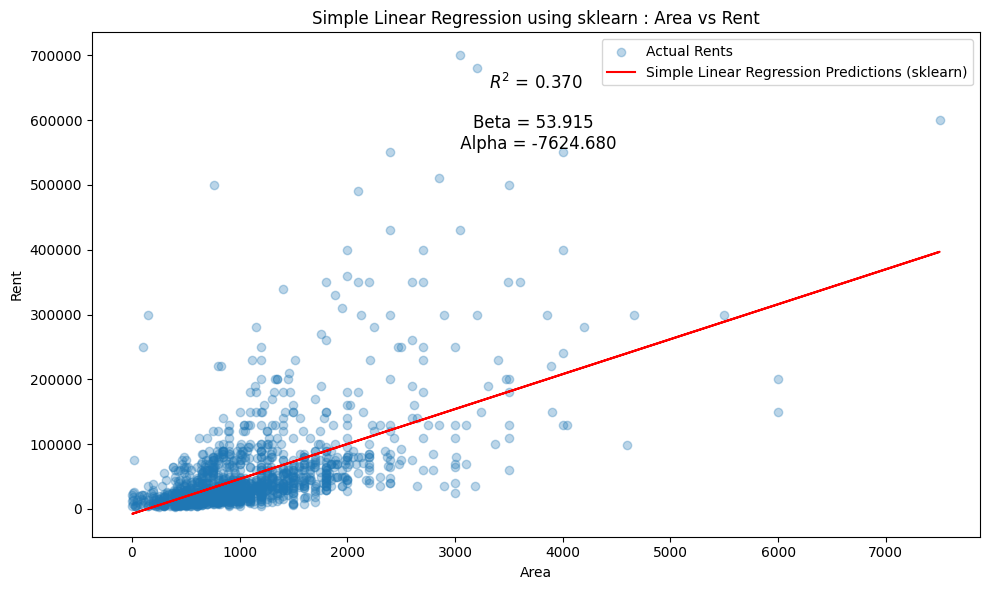

In [100]:
# Plotting Simple Linear Regression Predictions
fig, ax = plt.subplots(1, 1, figsize=(10,6)) 

# Plotting the simple linear regression predictions
ax.scatter(X_test, y_test, alpha=0.3, label='Actual Rents')
ax.plot(X_test, predictions_simple, color='red', label='Simple Linear Regression Predictions (sklearn)')
ax.text(0.5, 0.9, f'$R^2$ = {r2_simple:.3f}', ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax.text(0.5, 0.80, f'Beta = {beta_simple:.3f} \n Alpha = {alpha_simple:.3f}', ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax.set_title('Simple Linear Regression using sklearn : Area vs Rent')
ax.set_xlabel('Area')
ax.set_ylabel('Rent')
ax.legend()

plt.tight_layout()
plt.savefig('plots/simpleLinearRegression.svg')
plt.show()

## Question 9
What insights do you gather based on the outputs of part 8? Discuss the performance of your model, indicating limitations and providing recommendations, if any, to improve model performance.

insert answer here

# Appendix

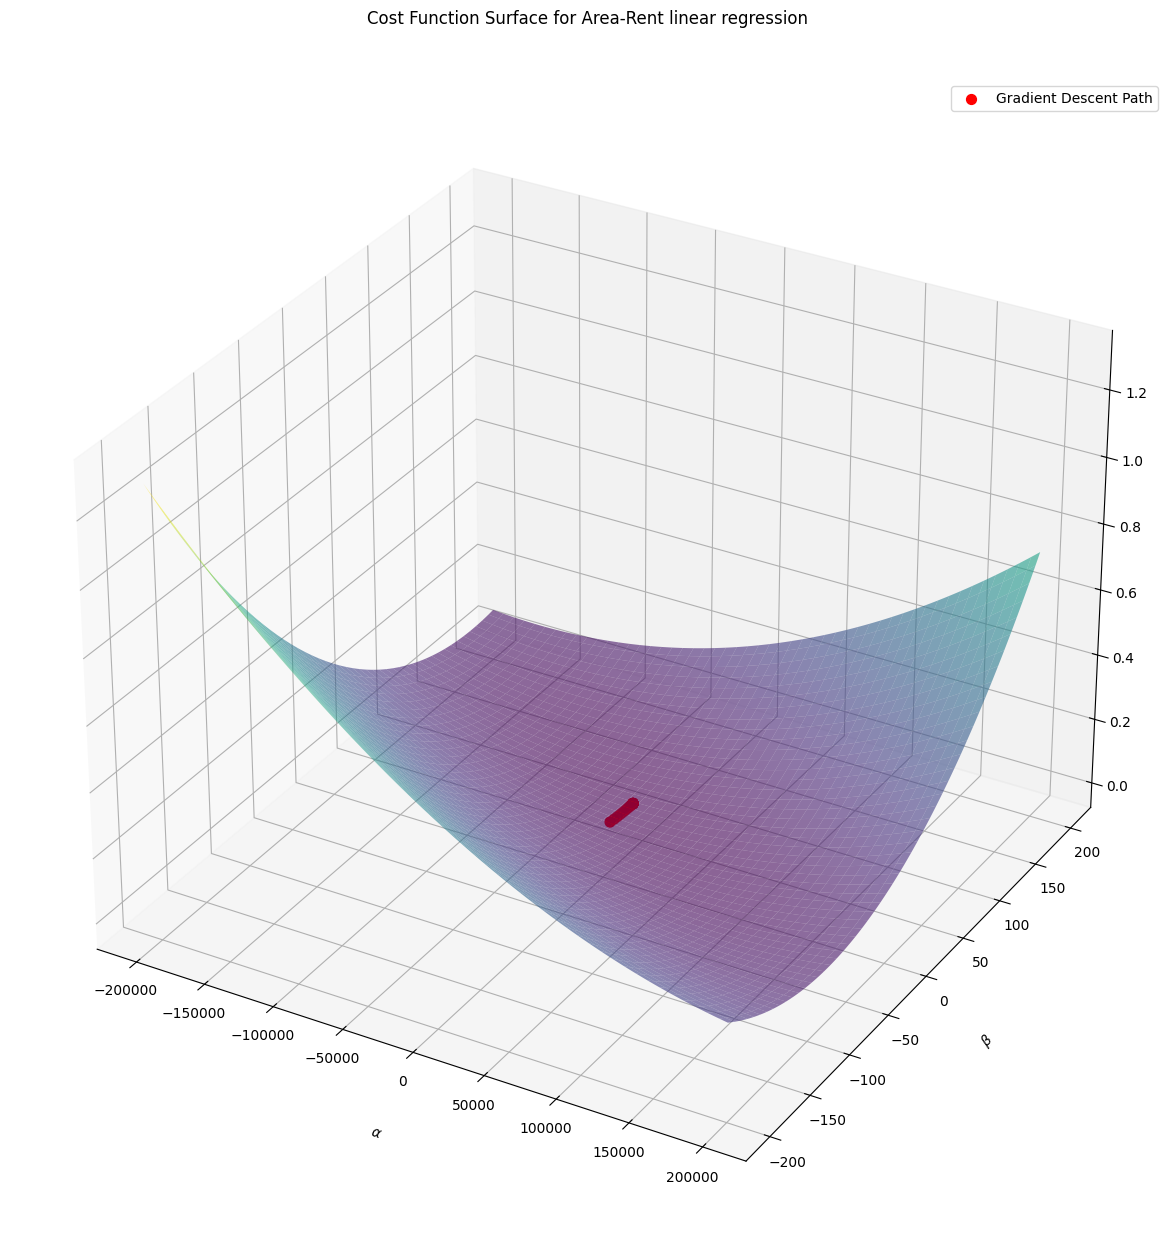

In [101]:
# appendix

# plotting the cost surface for a larger grid
grid = 200
alpha_plot = np.linspace(-200000, 200000, grid)
beta_plot= np.linspace(-200,200, grid)
alpha_plot, beta_plot = np.meshgrid(alpha_plot, beta_plot)
cost_plot = np.array([compute_cost(a, b, X, y) for a, b in zip(np.ravel(alpha_plot), np.ravel(beta_plot))])
cost_plot = cost_plot.reshape(alpha_plot.shape)

fig, ax = plt.subplots(1, 1, figsize=(20, 15), subplot_kw={'projection': '3d'})

# Plotting the cost function surface
ax.plot_surface(alpha_plot, beta_plot, cost_plot, cmap='viridis', alpha=0.6)

# Plotting the gradient descent path
ax.scatter(alpha_new, beta_new, cost_new, color='red', label='Gradient Descent Path', s=50)

ax.set_xlabel(r'$\alpha$', labelpad=20)
ax.set_ylabel(r'$\beta$', labelpad=20)
ax.set_zlabel(r'Cost $J(\alpha, \beta)$', labelpad=20)
ax.set_title('Cost Function Surface for Area-Rent linear regression', pad=40)
ax.legend()


# Adjust view angle
view = (20, 40)
